GPflow with TensorFlow 2
===

##### Small steps big changes

<br>



In [1]:
from typing import Tuple, Optional
import tempfile
import pathlib

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow

from gpflow.config import default_float
from gpflow.ci_utils import ci_niter
from gpflow.utilities import to_default_float

import warnings

warnings.filterwarnings("ignore")

2022-03-07 11:39:45.578860: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 11:39:45.578892: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Make `tensorboard` work inside notebook:

In [2]:
output_logdir = "/tmp/tensorboard"

!rm -rf "{output_logdir}"
!mkdir "{output_logdir}"

%load_ext tensorboard
%matplotlib inline


def enumerated_logdir(_logdir_id: int = [0]):
    logdir = pathlib.Path(output_logdir, str(_logdir_id[0]))
    _logdir_id[0] += 1
    return str(logdir)

Set up random seeds and default float for `gpflow` tensors:

In [3]:
gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)

## Loading data using TensorFlow Datasets

For this example, we create a synthetic dataset (noisy sine function):

2022-03-07 11:39:47.895248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-07 11:39:47.895282: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-07 11:39:47.895305: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b149603e3b87): /proc/driver/nvidia/version does not exist
2022-03-07 11:39:47.895727: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


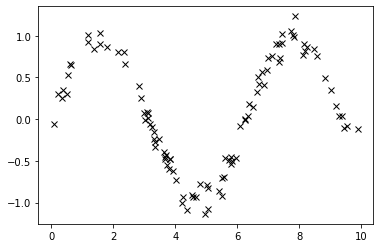

In [4]:
def noisy_sin(x):
    return tf.math.sin(x) + 0.1 * tf.random.normal(x.shape, dtype=default_float())


num_train_data, num_test_data = 100, 500

X = tf.random.uniform((num_train_data, 1), dtype=default_float()) * 10
Xtest = tf.random.uniform((num_test_data, 1), dtype=default_float()) * 10

Y = noisy_sin(X)
Ytest = noisy_sin(Xtest)

data = (X, Y)

plt.plot(X, Y, "xk")
plt.show()

Working with TensorFlow Datasets is an efficient way to rapidly shuffle, iterate, and batch from data. For `prefetch` size we use `tf.data.experimental.AUTOTUNE` as recommended by TensorFlow [guidelines](https://www.tensorflow.org/guide/data_performance).

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
test_dataset = tf.data.Dataset.from_tensor_slices((Xtest, Ytest))

batch_size = 32
num_features = 10
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = num_train_data // 2
num_batches_per_epoch = num_train_data // batch_size

original_train_dataset = train_dataset
train_dataset = (
    train_dataset.repeat()
    .prefetch(prefetch_size)
    .shuffle(buffer_size=shuffle_buffer_size)
    .batch(batch_size)
)

print(f"prefetch_size={prefetch_size}")
print(f"shuffle_buffer_size={shuffle_buffer_size}")
print(f"num_batches_per_epoch={num_batches_per_epoch}")

prefetch_size=-1
shuffle_buffer_size=50
num_batches_per_epoch=3


## Define a GP model

In GPflow 2.0, we use `tf.Module` (or the very thin `gpflow.base.Module` wrapper) to build all our models, as well as their components (kernels, likelihoods, parameters, and so on).

In [6]:
kernel = gpflow.kernels.SquaredExponential(variance=2.0)
likelihood = gpflow.likelihoods.Gaussian()
inducing_variable = np.linspace(0, 10, num_features).reshape(-1, 1)

model = gpflow.models.SVGP(
    kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable
)

You can set a module (or a particular parameter) to be non-trainable using the auxiliary method ```set_trainable(module, False)```:

In [7]:
from gpflow import set_trainable

set_trainable(likelihood, False)
set_trainable(kernel.variance, False)

set_trainable(likelihood, True)
set_trainable(kernel.variance, True)

2022-03-07 11:39:48.164082: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


We can use ```param.assign(value)``` to assign a value to a parameter:

In [8]:
kernel.lengthscales.assign(0.5)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-0.43275212956718856>

All these changes are reflected when we use ```print_summary(model)``` to print a detailed summary of the model. By default the output is displayed in a minimalistic and simple table.

In [9]:
from gpflow.utilities import print_summary

print_summary(model)  # same as print_summary(model, fmt="fancy_table")

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape       │ dtype   │ value            │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════╡
│ SVGP.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()          │ float64 │ 2.0              │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()          │ float64 │ 0.5              │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()          │ float64 │ 1.0

We can change default printing so that it will look nicer in our notebook:

In [10]:
gpflow.config.set_default_summary_fmt("notebook")

print_summary(model)  # same as print_summary(model, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.0
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.5
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(10, 1)",float64,[[0....
SVGP.q_mu,Parameter,Identity,,True,"(10, 1)",float64,[[0....
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 10, 10)",float64,"[[[1., 0., 0...."


Jupyter notebooks also format GPflow classes (that are subclasses of `gpflow.base.Module`) in the same nice way when at the end of a cell (this is independent of the `default_summary_fmt`):

In [11]:
model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.0
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.5
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(10, 1)",float64,[[0....
SVGP.q_mu,Parameter,Identity,,True,"(10, 1)",float64,[[0....
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 10, 10)",float64,"[[[1., 0., 0...."


## Training using training_loss and training_loss_closure

GPflow models come with training_loss and training_loss_closure methods to make it easy to train your models.
There is a slight difference between models that own their own data (most of them, e.g. GPR, VGP, ...) and models that do not own the data (SVGP).

### Model-internal data
For models that own their own data (inheriting from InternalDataTrainingLossMixin), data is provided at model construction time.
In this case, model.training_loss does not take any arguments, and can be directly passed to an optimizer's `minimize()` method:

In [12]:
vgp_model = gpflow.models.VGP(data, kernel, likelihood)
optimizer = tf.optimizers.Adam()
optimizer.minimize(
    vgp_model.training_loss, vgp_model.trainable_variables
)  # Note: this does a single step
# In practice, you will need to call minimize() many times, this will be further discussed below.

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

This also works for the Scipy optimizer, though it will do the full optimization on a single call to minimize():

In [13]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(
    vgp_model.training_loss, vgp_model.trainable_variables, options=dict(maxiter=ci_niter(1000))
)

2022-03-07 11:39:50.742018: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


      fun: -67.28079116205669
 hess_inv: <5153x5153 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.02691154,  0.01459887, -0.00436028, ...,  0.05020117,
       -0.00861012, -0.00273759])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 691
      nit: 652
     njev: 691
   status: 0
  success: True
        x: array([-0.19058673,  1.64209811,  0.02528677, ...,  1.7168368 ,
        0.78004409, -4.65256065])

You can obtain a compiled version using training_loss_closure, whose `compile` argument is True by default:

In [14]:
vgp_model.training_loss_closure()  # compiled
vgp_model.training_loss_closure(compile=True)  # compiled
vgp_model.training_loss_closure(compile=False)  # uncompiled, same as vgp_model.training_loss

<bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x7f4f5d4ef210>>

### External data

The SVGP model inherits from ExternalDataTrainingLossMixin and expects the data to be passed to training_loss().
For SVGP as for the other regression models, `data` is a two-tuple of `(X, Y)`, where `X` is an array/tensor with shape `(num_data, input_dim)` and `Y` is an array/tensor with shape `(num_data, output_dim)`:

In [15]:
assert isinstance(model, gpflow.models.SVGP)
model.training_loss(data)

<tf.Tensor: shape=(), dtype=float64, numpy=8169.065340796262>

To make optimizing it easy, it has a `training_loss_closure()` method, that takes the data and returns a closure that computes the training loss on this data:

In [16]:
optimizer = tf.optimizers.Adam()
training_loss = model.training_loss_closure(
    data
)  # We save the compiled closure in a variable so as not to re-compile it each step
optimizer.minimize(training_loss, model.trainable_variables)  # Note that this does a single step

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

SVGP can handle mini-batching, and an iterator from a batched tf.data.Dataset can be passed to the model's training_loss_closure():

In [17]:
batch_size = 5
batched_dataset = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)
training_loss = model.training_loss_closure(iter(batched_dataset))

optimizer.minimize(training_loss, model.trainable_variables)  # Note that this does a single step

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=2>

As previously, training_loss_closure takes an optional `compile` argument for tf.function compilation (True by default).

## Training using Gradient Tapes

For a more elaborate example of a gradient update we can define an `optimization_step` that explicitly computes and applies gradients to the model.
In TensorFlow 2, we can optimize (trainable) model parameters with TensorFlow optimizers using `tf.GradientTape`. In this simple example, we perform one gradient update of the Adam optimizer to minimize the training_loss (in this case the negative ELBO) of our model.
The `optimization_step` can (and should) be wrapped in `tf.function` to be compiled to a graph if executing it many times.

In [18]:
def optimization_step(model: gpflow.models.SVGP, batch: Tuple[tf.Tensor, tf.Tensor]):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        loss = model.training_loss(batch)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

We can use the functionality of TensorFlow Datasets to define a simple training loop that iterates over batches of the training dataset:

In [19]:
def simple_training_loop(model: gpflow.models.SVGP, epochs: int = 1, logging_epoch_freq: int = 10):
    tf_optimization_step = tf.function(optimization_step)

    batches = iter(train_dataset)
    for epoch in range(epochs):
        for _ in range(ci_niter(num_batches_per_epoch)):
            tf_optimization_step(model, next(batches))

        epoch_id = epoch + 1
        if epoch_id % logging_epoch_freq == 0:
            tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(data)}")

In [20]:
simple_training_loop(model, epochs=10, logging_epoch_freq=2)

Epoch 2: ELBO (train) -7898.854260635546


Epoch 4: ELBO (train) -7695.562257882305


Epoch 6: ELBO (train) -7490.046346329913


Epoch 8: ELBO (train) -7286.5495827288


Epoch 10: ELBO (train) -7086.454568633618


## Monitoring

`gpflow.monitor` provides a thin wrapper on top of tf.summary that makes it easy to monitor the training procedure.
For a more detailed tutorial see the [monitoring notebook](./basics/monitoring.pct.py).

In [21]:
from gpflow.monitor import (
    ImageToTensorBoard,
    ModelToTensorBoard,
    ExecuteCallback,
    Monitor,
    MonitorTaskGroup,
    ScalarToTensorBoard,
)


samples_input = np.linspace(0, 10, 100).reshape(-1, 1)


def plot_model(fig, ax):
    tf.print("Plotting...")
    mean, var = model.predict_f(samples_input)
    num_samples = 10
    samples = model.predict_f_samples(samples_input, num_samples)
    ax.plot(samples_input, mean, "C0", lw=2)
    ax.fill_between(
        samples_input[:, 0],
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        color="C0",
        alpha=0.2,
    )
    ax.plot(X, Y, "kx")
    ax.plot(samples_input, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
    ax.set_ylim(-2.0, +2.0)
    ax.set_xlim(0, 10)


def print_cb(epoch_id=None, data=None):
    tf.print(f"Epoch {epoch_id}: ELBO (train)", model.elbo(data))


def elbo_cb(data=None, **_):
    return model.elbo(data)


output_logdir = enumerated_logdir()

model_task = ModelToTensorBoard(output_logdir, model)
elbo_task = ScalarToTensorBoard(output_logdir, elbo_cb, "elbo")
print_task = ExecuteCallback(callback=print_cb)

# We group these tasks and specify a period of `100` steps for them
fast_tasks = MonitorTaskGroup([model_task, elbo_task, print_task], period=100)

# We also want to see the model's fit during the optimisation
image_task = ImageToTensorBoard(output_logdir, plot_model, "samples_image")

# We typically don't want to plot too frequently during optimisation,
# which is why we specify a larger period for this task.
slow_taks = MonitorTaskGroup(image_task, period=500)
monitor = Monitor(fast_tasks, slow_taks)


def monitored_training_loop(epochs: int):
    tf_optimization_step = tf.function(optimization_step)

    batches = iter(train_dataset)

    for epoch in range(epochs):
        for _ in range(ci_niter(num_batches_per_epoch)):
            batch = next(batches)
            tf_optimization_step(model, batch)

        epoch_id = epoch + 1
        monitor(epoch, epoch_id=epoch_id, data=data)

NOTE: for optimal performance it is recommended to wrap the monitoring inside `tf.function`.
This is detailed in the [monitoring notebook](./basics/monitoring.ipynb).

In [22]:
model = gpflow.models.SVGP(
    kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable
)

monitored_training_loop(epochs=1000)

Epoch 1: ELBO (train) -7762.6662086221522


Plotting...


Cleanup called...


Epoch 101: ELBO (train) -2016.4355973646502


Epoch 201: ELBO (train) -838.528656188451


Epoch 301: ELBO (train) -369.20119278473118


Epoch 401: ELBO (train) -155.54011033976627


Epoch 501: ELBO (train) -53.708026016091175


Plotting...


Cleanup called...


Epoch 601: ELBO (train) -7.2030060045769524


Epoch 701: ELBO (train) 14.869034007581284


Epoch 801: ELBO (train) 26.988733531958971


Epoch 901: ELBO (train) 34.639336530676552


Then, we can use TensorBoard to examine the training procedure in more detail

In [23]:
# %tensorboard --logdir "{output_logdir}"

## Saving and loading models

### Checkpointing

With the help of `tf.train.CheckpointManager` and `tf.train.Checkpoint`, we can checkpoint the model throughout the training procedure. Let's start with a simple example using checkpointing to save and load a `tf.Variable`:

In [24]:
initial_value = 1.2
a = tf.Variable(initial_value)

Create `Checkpoint` object:

In [25]:
ckpt = tf.train.Checkpoint(a=a)
manager = tf.train.CheckpointManager(ckpt, output_logdir, max_to_keep=3)

Save the variable `a` and change its value right after:

In [26]:
manager.save()
_ = a.assign(0.33)

Now we can restore the old variable value:

In [27]:
print(f"Current value of variable a: {a.numpy():0.3f}")

ckpt.restore(manager.latest_checkpoint)

print(f"Value of variable a after restore: {a.numpy():0.3f}")

Current value of variable a: 0.330
Value of variable a after restore: 1.200


In the example below, we modify a simple training loop to save the model every 100 epochs using the `CheckpointManager`.

In [28]:
model = gpflow.models.SVGP(
    kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable
)


def checkpointing_training_loop(
    model: gpflow.models.SVGP,
    batch_size: int,
    epochs: int,
    manager: tf.train.CheckpointManager,
    logging_epoch_freq: int = 100,
    epoch_var: Optional[tf.Variable] = None,
    step_var: Optional[tf.Variable] = None,
):
    tf_optimization_step = tf.function(optimization_step)

    batches = iter(train_dataset)

    for epoch in range(epochs):
        for step in range(ci_niter(num_batches_per_epoch)):
            tf_optimization_step(model, next(batches))
            if step_var is not None:
                step_var.assign(epoch * num_batches_per_epoch + step + 1)
        if epoch_var is not None:
            epoch_var.assign(epoch + 1)

        epoch_id = epoch + 1
        if epoch_id % logging_epoch_freq == 0:
            ckpt_path = manager.save()
            tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(data)}, saved at {ckpt_path}")

In [29]:
step_var = tf.Variable(1, dtype=tf.int32, trainable=False)
epoch_var = tf.Variable(1, dtype=tf.int32, trainable=False)
ckpt = tf.train.Checkpoint(model=model, step=step_var, epoch=epoch_var)
manager = tf.train.CheckpointManager(ckpt, output_logdir, max_to_keep=5)

print(f"Checkpoint folder path at: {output_logdir}")

checkpointing_training_loop(
    model,
    batch_size=batch_size,
    epochs=1000,
    manager=manager,
    epoch_var=epoch_var,
    step_var=step_var,
)

Checkpoint folder path at: /tmp/tensorboard/0


Epoch 100: ELBO (train) -148.7633723558392, saved at /tmp/tensorboard/0/ckpt-1


Epoch 200: ELBO (train) -8.281638769815281, saved at /tmp/tensorboard/0/ckpt-2


Epoch 300: ELBO (train) 24.841307077177735, saved at /tmp/tensorboard/0/ckpt-3


Epoch 400: ELBO (train) 36.77522554100095, saved at /tmp/tensorboard/0/ckpt-4


Epoch 500: ELBO (train) 42.13388390452799, saved at /tmp/tensorboard/0/ckpt-5


Epoch 600: ELBO (train) 45.04693993443813, saved at /tmp/tensorboard/0/ckpt-6


Epoch 700: ELBO (train) 46.89634130045864, saved at /tmp/tensorboard/0/ckpt-7


Epoch 800: ELBO (train) 48.22510708972089, saved at /tmp/tensorboard/0/ckpt-8


Epoch 900: ELBO (train) 49.27538845459077, saved at /tmp/tensorboard/0/ckpt-9


Epoch 1000: ELBO (train) 50.17219733401792, saved at /tmp/tensorboard/0/ckpt-10


After the models have been saved, we can restore them using ```tf.train.Checkpoint.restore``` and assert that their performance corresponds to that logged during training.

In [30]:
for i, recorded_checkpoint in enumerate(manager.checkpoints):
    ckpt.restore(recorded_checkpoint)
    print(
        f"{i} restored model from epoch {int(epoch_var)} [step:{int(step_var)}] : ELBO training set {model.elbo(data)}"
    )

0 restored model from epoch 600 [step:1800] : ELBO training set 45.04693993443813
1 restored model from epoch 700 [step:2100] : ELBO training set 46.89634130045864
2 restored model from epoch 800 [step:2400] : ELBO training set 48.22510708972089
3 restored model from epoch 900 [step:2700] : ELBO training set 49.27538845459077
4 restored model from epoch 1000 [step:3000] : ELBO training set 50.17219733401792


### Copying (hyper)parameter values between models

It is easy to interact with the set of all parameters of a model or a subcomponent programmatically.

The following returns a dictionary of all parameters within

In [31]:
model = gpflow.models.SGPR(data, kernel=kernel, inducing_variable=inducing_variable)

In [32]:
gpflow.utilities.parameter_dict(model)

{'.kernel.variance': <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.8871404585083305>,
 '.kernel.lengthscales': <Parameter: dtype=float64, shape=[], fn="softplus", numpy=1.6798650145312535>,
 '.likelihood.variance': <Parameter: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=1.0>,
 '.inducing_variable.Z': <Parameter: dtype=float64, shape=[10, 1], fn="identity", numpy=
 array([[ 0.        ],
        [ 1.11111111],
        [ 2.22222222],
        [ 3.33333333],
        [ 4.44444444],
        [ 5.55555556],
        [ 6.66666667],
        [ 7.77777778],
        [ 8.88888889],
        [10.        ]])>}

Such a dictionary can be assigned back to this model (or another model with the same tree of parameters) as follows:

In [33]:
params = gpflow.utilities.parameter_dict(model)
gpflow.utilities.multiple_assign(model, params)

### TensorFlow `saved_model`

In order to save the model we need to explicitly store the `tf.function`-compiled functions that we wish to export:

In [34]:
model.predict_f_compiled = tf.function(
    model.predict_f, input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float64)]
)

We also save the original prediction for later comparison. Here `samples_input` needs to be a tensor so that `tf.function` will compile a single graph:

In [35]:
samples_input = tf.convert_to_tensor(samples_input, dtype=default_float())
original_result = model.predict_f_compiled(samples_input)

Let's save the model:

In [36]:
save_dir = str(pathlib.Path(tempfile.gettempdir()))
tf.saved_model.save(model, save_dir)

Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


We can load the module back as a new instance and compare the prediction results:

In [37]:
loaded_model = tf.saved_model.load(save_dir)
loaded_result = loaded_model.predict_f_compiled(samples_input)

np.testing.assert_array_equal(loaded_result, original_result)

## User config update

In this notebook, we used a lot `gpflow.config` methods for setting and getting default attributes from global configuration. However, GPflow provides a way for local config modification without updating values in global. As you can see below, using `gpflow.config.as_context` replaces temporarily global config with your instance. At creation time, custom config instance uses standard values from the global config:

In [38]:
user_config = gpflow.config.Config(float=tf.float32, positive_bijector="exp")

user_str = "User config\t"
global_str = "Global config\t"

with gpflow.config.as_context(user_config):
    print(f"{user_str} gpflow.config.default_float = {gpflow.config.default_float()}")
    print(
        f"{user_str} gpflow.config.positive_bijector = {gpflow.config.default_positive_bijector()}"
    )

print(f"{global_str} gpflow.config.default_float = {gpflow.config.default_float()}")
print(f"{global_str} gpflow.config.positive_bijector = {gpflow.config.default_positive_bijector()}")

User config	 gpflow.config.default_float = <dtype: 'float32'>
User config	 gpflow.config.positive_bijector = exp
Global config	 gpflow.config.default_float = <class 'numpy.float64'>
Global config	 gpflow.config.positive_bijector = softplus


In [39]:
with gpflow.config.as_context(user_config):
    p = gpflow.Parameter(1.1, transform=gpflow.utilities.positive())
    print(f"{user_str}{p}")

p = gpflow.Parameter(1.1, transform=gpflow.utilities.positive())
print(f"{global_str}{p}")

User config	<Parameter: dtype=float32, shape=[], fn="exp", numpy=1.1>
Global config	<Parameter: dtype=float64, shape=[], fn="softplus", numpy=1.1>
